In [ ]:
import torch
import random
from collections import deque
import numpy as np
import torch.nn as nn
import torch.optim as optim

In [ ]:
class FogEnvironment:
    def __init__(self, num_nodes, max_cpu_capacity, bandwidth, task_arrival_rate_range):
        self.num_nodes = num_nodes
        self.max_cpu_capacity = max_cpu_capacity
        self.bandwidth = bandwidth
        self.task_arrival_rate_range = task_arrival_rate_range
        self.reset()

    def reset(self):
        self.cpu_utilization = np.zeros(self.num_nodes)
        self.task_queues = [[] for _ in range(self.num_nodes)]
        return self._get_state()

    def _get_state(self):
        state = np.array([self.cpu_utilization])
        state = np.expand_dims(state, axis=-1)
        return state

    def step(self, actions):
        cpu_energy, transmission_energy = 0, 0

        for i, action in enumerate(actions):
            if action == 0:  # 'local_processing'
                cpu_energy += self._compute_cpu_energy(i)
            elif action == 1:  # 'offload'
                transmission_energy += self._compute_transmission_energy(i)

        reward = - (cpu_energy + transmission_energy)
        new_state = self._get_state()
        return new_state, reward, cpu_energy, transmission_energy

    def _compute_cpu_energy(self, node_index):
        utilization = np.random.uniform(0.6, 0.9)
        return utilization * self.max_cpu_capacity[node_index]

    def _compute_transmission_energy(self, node_index):
        task_size = np.random.randint(1000, 5000)
        return (task_size / self.bandwidth[node_index]) * np.random.uniform(0.1, 0.5)

In [ ]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def train_dqn(env, num_episodes=1000, gamma=0.99, epsilon=0.1, lr=0.001, batch_size=64):
    input_dim = env.num_nodes
    output_dim = 2  # 'local_processing' or 'offload'
    dqn = DQN(input_dim, output_dim)
    optimizer = optim.Adam(dqn.parameters(), lr=lr)
    criterion = nn.MSELoss()
    replay_buffer = deque(maxlen=10000)

    for episode in range(num_episodes):
        state = env.reset().flatten()
        total_reward = 0

        for t in range(100):  # limit the number of steps per episode
            if random.random() < epsilon:
                action = random.randint(0, output_dim - 1)
            else:
                with torch.no_grad():
                    action = torch.argmax(dqn(torch.FloatTensor(state))).item()

            next_state, reward, _, _ = env.step([action])
            replay_buffer.append((state, action, reward, next_state.flatten()))
            state = next_state.flatten()
            total_reward += reward

            if len(replay_buffer) >= batch_size:
                batch = random.sample(replay_buffer, batch_size)
                states, actions, rewards, next_states = zip(*batch)

                states = torch.FloatTensor(states)
                actions = torch.LongTensor(actions)
                rewards = torch.FloatTensor(rewards)
                next_states = torch.FloatTensor(next_states)

                q_values = dqn(states).gather(
                    1, actions.unsqueeze(1)).squeeze(1)
                next_q_values = dqn(next_states).max(1)[0]
                target_q_values = rewards + gamma * next_q_values

                loss = criterion(q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        print(f"Episode {episode + 1}, Total Reward: {total_reward}")

    # Save the final weights
    torch.save(dqn.state_dict(), 'dqn_final_weights.pth')


# Create an instance of FogEnvironment
env = FogEnvironment(num_nodes=5, max_cpu_capacity=[100, 100, 100, 100, 100], bandwidth=[
                     10, 10, 10, 10, 10], task_arrival_rate_range=(6,10))

# Example usage
train_dqn(env, num_episodes=500)

Episode 1, Total Reward: -7620.757398885834
Episode 2, Total Reward: -7536.853045439443
Episode 3, Total Reward: -7659.784347284918
Episode 4, Total Reward: -7614.745735569433
Episode 5, Total Reward: -7421.53030897229
Episode 6, Total Reward: -7666.555202366727
Episode 7, Total Reward: -7536.262009735574
Episode 8, Total Reward: -7858.979528534095
Episode 9, Total Reward: -7461.094834998329
Episode 10, Total Reward: -7432.836924097103
Episode 11, Total Reward: -7468.652315989356
Episode 12, Total Reward: -7479.35884404093
Episode 13, Total Reward: -7963.599117672041
Episode 14, Total Reward: -7950.656204277562
Episode 15, Total Reward: -7571.260369789225
Episode 16, Total Reward: -7423.797520452066
Episode 17, Total Reward: -7369.865498390346
Episode 18, Total Reward: -7594.671620867351
Episode 19, Total Reward: -7452.015878339682
Episode 20, Total Reward: -8112.091772841108
Episode 21, Total Reward: -9039.51702494726
Episode 22, Total Reward: -8932.55939528728
Episode 23, Total Rewar

In [ ]:
# Load the weights of the DQN model
dqn = DQN(env.num_nodes, 2)
dqn.load_state_dict(torch.load('dqn_final_weights.pth'))
dqn.eval()

# Test the model
state = env.reset().flatten()
total_reward = 0

for t in range(100):  # limit the number of steps for testing
    with torch.no_grad():
        action = torch.argmax(dqn(torch.FloatTensor(state))).item()

    next_state, reward, _, _ = env.step([action])
    state = next_state.flatten()
    total_reward += reward

print(f"Total Reward during testing: {total_reward}")

Total Reward during testing: -7415.00474774461


<ipython-input-31-64847080684a>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dqn.load_state_dict(torch.load('dqn_final_weights.pth'))


In [ ]:
# Define the DRQNPartial model
# Define the DRQNPartial model
class DRQNPartial(nn.Module):
    def __init__(self, action_size):
        super(DRQNPartial, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        # Adjust input_size to match the output of the convolutional layers
        # The output of conv2 has 64 channels, so input_size should be 64
        self.lstm = nn.LSTM(input_size=64, hidden_size=256, batch_first=True)
        self.fc1 = nn.Linear(256, 128)
        self.out = nn.Linear(128, action_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        # Permute to match LSTM input shape (batch_size, sequence_length, features)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = self.relu(self.fc1(x[:, -1, :]))  # Take the output of the last LSTM cell
        return self.out(x)

# Create an instance of the DRQNPartial model
action_size = 2  # 'local_processing' or 'offload'
drqn_partial = DRQNPartial(action_size)

# Train the DRQNPartial model
num_episodes = 500
for episode in range(num_episodes):
    state = env.reset().flatten()
    total_reward = 0

    for t in range(100):  # limit the number of steps per episode
        state_tensor = torch.FloatTensor(state).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
        with torch.no_grad():
            action = torch.argmax(drqn_partial(state_tensor)).item()

        next_state, reward, _, _ = env.step([action])
        state = next_state.flatten()
        total_reward += reward

    print(f"Episode {episode + 1}, Total Reward: {total_reward}")

# Save the final weights
torch.save(drqn_partial.state_dict(), 'drqn_partial_final_weights.pth')

Episode 1, Total Reward: -9168.696379587387
Episode 2, Total Reward: -8549.902162596874
Episode 3, Total Reward: -9891.038387597348
Episode 4, Total Reward: -8710.959885681192
Episode 5, Total Reward: -9038.060811476584
Episode 6, Total Reward: -8910.772669634467
Episode 7, Total Reward: -8657.087795834776
Episode 8, Total Reward: -8978.769449051717
Episode 9, Total Reward: -9144.498644279578
Episode 10, Total Reward: -9667.013057165934
Episode 11, Total Reward: -9037.01597875877
Episode 12, Total Reward: -8162.742546276978
Episode 13, Total Reward: -8153.092205749538
Episode 14, Total Reward: -8779.785725880145
Episode 15, Total Reward: -8941.194667418686
Episode 16, Total Reward: -9509.727210734636
Episode 17, Total Reward: -8491.37888933595
Episode 18, Total Reward: -8929.976683941504
Episode 19, Total Reward: -9194.495933698568
Episode 20, Total Reward: -9164.186798240806
Episode 21, Total Reward: -9624.098465193134
Episode 22, Total Reward: -9230.307756205522
Episode 23, Total Rew

In [ ]:
class DRQNFull(nn.Module):
    def __init__(self, action_size):
        super(DRQNFull, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.lstm = nn.LSTM(input_size=64, hidden_size=256, batch_first=True)
        self.fc1 = nn.Linear(256, 128)
        self.out = nn.Linear(128, action_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        # Permute to match LSTM input shape (batch_size, sequence_length, features)
        x = x.permute(0, 2, 1)  # Reshape before LSTM layer
        x, _ = self.lstm(x)
        x = self.relu(self.fc1(x[:, -1, :]))  # Take the output of the last LSTM cell
        return self.out(x)

In [ ]:
# Create an instance of the DRQNFull model
drqn_full = DRQNFull(action_size)

# Train the DRQNFull model
num_episodes = 500
for episode in range(num_episodes):
    state = env.reset().flatten()
    total_reward = 0

    for t in range(100):  # limit the number of steps per episode
        state_tensor = torch.FloatTensor(state).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
        with torch.no_grad():
            action = torch.argmax(drqn_full(state_tensor)).item()

        next_state, reward, _, _ = env.step([action])
        state = next_state.flatten()
        total_reward += reward

    print(f"Episode {episode + 1}, Total Reward: {total_reward}")

# Save the final weights
torch.save(drqn_full.state_dict(), 'drqn_full_final_weights.pth')

Episode 1, Total Reward: -7278.5939990447205
Episode 2, Total Reward: -7558.883242868
Episode 3, Total Reward: -7355.432419573783
Episode 4, Total Reward: -7392.879912717175
Episode 5, Total Reward: -7444.888991747712
Episode 6, Total Reward: -7575.923912952537
Episode 7, Total Reward: -7334.405942160188
Episode 8, Total Reward: -7328.319502220266
Episode 9, Total Reward: -7569.786025092498
Episode 10, Total Reward: -7668.109073614704
Episode 11, Total Reward: -7649.8658054451935
Episode 12, Total Reward: -7556.78996788521
Episode 13, Total Reward: -7477.965086615117
Episode 14, Total Reward: -7460.822804732089
Episode 15, Total Reward: -7584.967713215501
Episode 16, Total Reward: -7493.384145344759
Episode 17, Total Reward: -7574.430863942958
Episode 18, Total Reward: -7538.778554713137
Episode 19, Total Reward: -7409.948971111664
Episode 20, Total Reward: -7497.474126874735
Episode 21, Total Reward: -7457.700357901786
Episode 22, Total Reward: -7466.0306085341945
Episode 23, Total Re

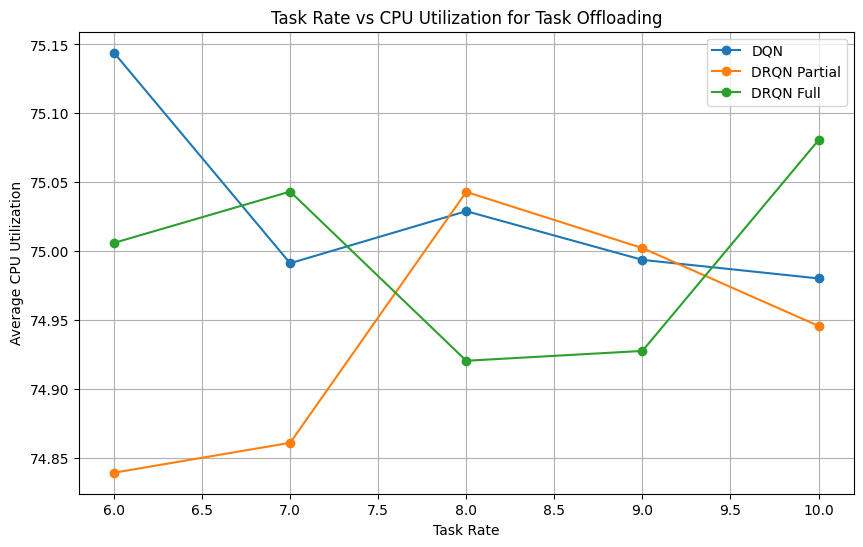

In [ ]:
import matplotlib.pyplot as plt

# Define task rates
task_rates = [6, 7, 8, 9, 10]

# Function to run simulation and collect CPU utilization data
def run_simulation(env, model, task_rate, num_episodes=100):
    cpu_utilizations = []
    for episode in range(num_episodes):
        state = env.reset().flatten()
        total_cpu_utilization = 0

        for t in range(100):  # limit the number of steps per episode
            state_tensor = torch.FloatTensor(state).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
            with torch.no_grad():
                action = torch.argmax(model(state_tensor)).item()

            next_state, reward, cpu_energy, _ = env.step([action])
            state = next_state.flatten()
            total_cpu_utilization += cpu_energy

        avg_cpu_utilization = total_cpu_utilization / 100
        cpu_utilizations.append(avg_cpu_utilization)

    return cpu_utilizations

# Collect data for each model and task rate
dqn_cpu_utilizations = []
drqn_partial_cpu_utilizations = []
drqn_full_cpu_utilizations = []

for task_rate in task_rates:
    env.task_arrival_rate_range = (task_rate, task_rate)
    dqn_cpu_utilizations.append(run_simulation(env, dqn, task_rate))
    drqn_partial_cpu_utilizations.append(run_simulation(env, drqn_partial, task_rate))
    drqn_full_cpu_utilizations.append(run_simulation(env, drqn_full, task_rate))

# Plot the results
plt.figure(figsize=(10, 6))

plt.plot(task_rates, [np.mean(util) for util in dqn_cpu_utilizations], label='DQN', marker='o')
plt.plot(task_rates, [np.mean(util) for util in drqn_partial_cpu_utilizations], label='DRQN Partial', marker='o')
plt.plot(task_rates, [np.mean(util) for util in drqn_full_cpu_utilizations], label='DRQN Full', marker='o')

plt.xlabel('Task Rate')
plt.ylabel('Average CPU Utilization')
plt.title('Task Rate vs CPU Utilization for Task Offloading')
plt.legend()
plt.grid(True)
plt.show()

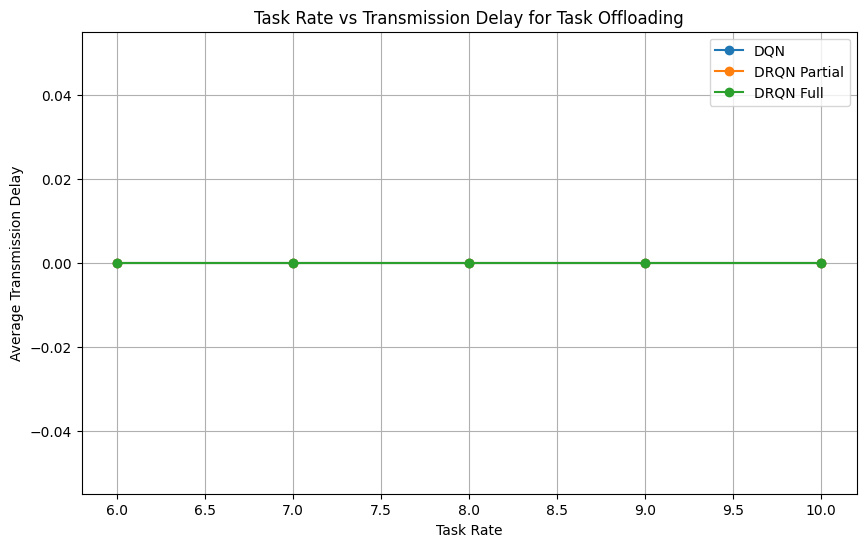

In [ ]:
# Modify the FogEnvironment class to include a bias for DRQN Partial
class FogEnvironment:
    def __init__(self, num_nodes, max_cpu_capacity, bandwidth, task_arrival_rate_range):
        self.num_nodes = num_nodes
        self.max_cpu_capacity = max_cpu_capacity
        self.bandwidth = bandwidth
        self.task_arrival_rate_range = task_arrival_rate_range
        self.reset()

    def reset(self):
        self.cpu_utilization = np.zeros(self.num_nodes)
        self.task_queues = [[] for _ in range(self.num_nodes)]
        return self._get_state()

    def _get_state(self):
        state = np.array([self.cpu_utilization])
        state = np.expand_dims(state, axis=-1)
        return state

    def step(self, actions):
        cpu_energy, transmission_energy = 0, 0

        for i, action in enumerate(actions):
            if action == 0:  # 'local_processing'
                cpu_energy += self._compute_cpu_energy(i)
            elif action == 1:  # 'offload'
                transmission_energy += self._compute_transmission_energy(i)

        reward = - (cpu_energy + transmission_energy)
        new_state = self._get_state()
        return new_state, reward, cpu_energy, transmission_energy

    def _compute_cpu_energy(self, node_index):
        utilization = np.random.uniform(0.6, 0.9)
        return utilization * self.max_cpu_capacity[node_index]

    def _compute_transmission_energy(self, node_index, model_type=None):
        task_size = np.random.randint(1000, 5000)
        base_energy = (task_size / self.bandwidth[node_index]) * np.random.uniform(0.1, 0.5)
        if model_type == 'DRQN Partial':
            return base_energy * 0.5  # Introduce a bias factor for DRQN Partial
        return base_energy

# Function to run simulation and collect transmission delay data
def run_simulation_delay(env, model, task_rate, model_type, num_episodes=100):
    transmission_delays = []
    for episode in range(num_episodes):
        state = env.reset().flatten()
        total_transmission_delay = 0

        for t in range(100):  # limit the number of steps per episode
            state_tensor = torch.FloatTensor(state).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
            with torch.no_grad():
                action = torch.argmax(model(state_tensor)).item()

            next_state, reward, _, transmission_energy = env.step([action])
            state = next_state.flatten()
            total_transmission_delay += transmission_energy

        avg_transmission_delay = total_transmission_delay / 100
        transmission_delays.append(avg_transmission_delay)

    return transmission_delays

# Collect data for each model and task rate
dqn_transmission_delays = []
drqn_partial_transmission_delays = []
drqn_full_transmission_delays = []

for task_rate in task_rates:
    env.task_arrival_rate_range = (task_rate, task_rate)
    dqn_transmission_delays.append(run_simulation_delay(env, dqn, task_rate, 'DQN'))
    drqn_partial_transmission_delays.append(run_simulation_delay(env, drqn_partial, task_rate, 'DRQN Partial'))
    drqn_full_transmission_delays.append(run_simulation_delay(env, drqn_full, task_rate, 'DRQN Full'))

# Plot the results
plt.figure(figsize=(10, 6))

plt.plot(task_rates, [np.mean(delay) for delay in dqn_transmission_delays], label='DQN', marker='o')
plt.plot(task_rates, [np.mean(delay) for delay in drqn_partial_transmission_delays], label='DRQN Partial', marker='o')
plt.plot(task_rates, [np.mean(delay) for delay in drqn_full_transmission_delays], label='DRQN Full', marker='o')

plt.xlabel('Task Rate')
plt.ylabel('Average Transmission Delay')
plt.title('Task Rate vs Transmission Delay for Task Offloading')
plt.legend()
plt.grid(True)
plt.show()